# Pennycook 2018 - light reanalysis

Pennycook, G., & Rand, D. G. (2018). Lazy, not biased: Susceptibility to partisan fake news is better explained by lack of reasoning than by motivated reasoning. Cognition.
https://www.sciencedirect.com/science/article/pii/S001002771830163X

Related blog from Dan Kahan
http://www.culturalcognition.net/blog/2018/10/25/who-falls-for-fake-news-apparently-no-one.html

Raw data available at:

https://osf.io/f5dgh/

In [1]:
#import libraries and raw data
import pandas as pd #dataframes
import numpy as np #number functions
import matplotlib.pyplot as plt #plotting
import seaborn as sns #fancy plotting
%matplotlib inline 
plt.rcParams['figure.figsize'] = [20, 12] #make default image size bigger
import warnings; warnings.simplefilter('ignore')

#import the data that I already downloaded from OSF
df1=pd.read_csv('Pennycook & Rand (Study 1).csv')


In [2]:
print("We have " +str(len(df1)) + " rows of data (participants?)")

We have 802 rows of data (participants?)


Text(0,0.5,'Frequency')

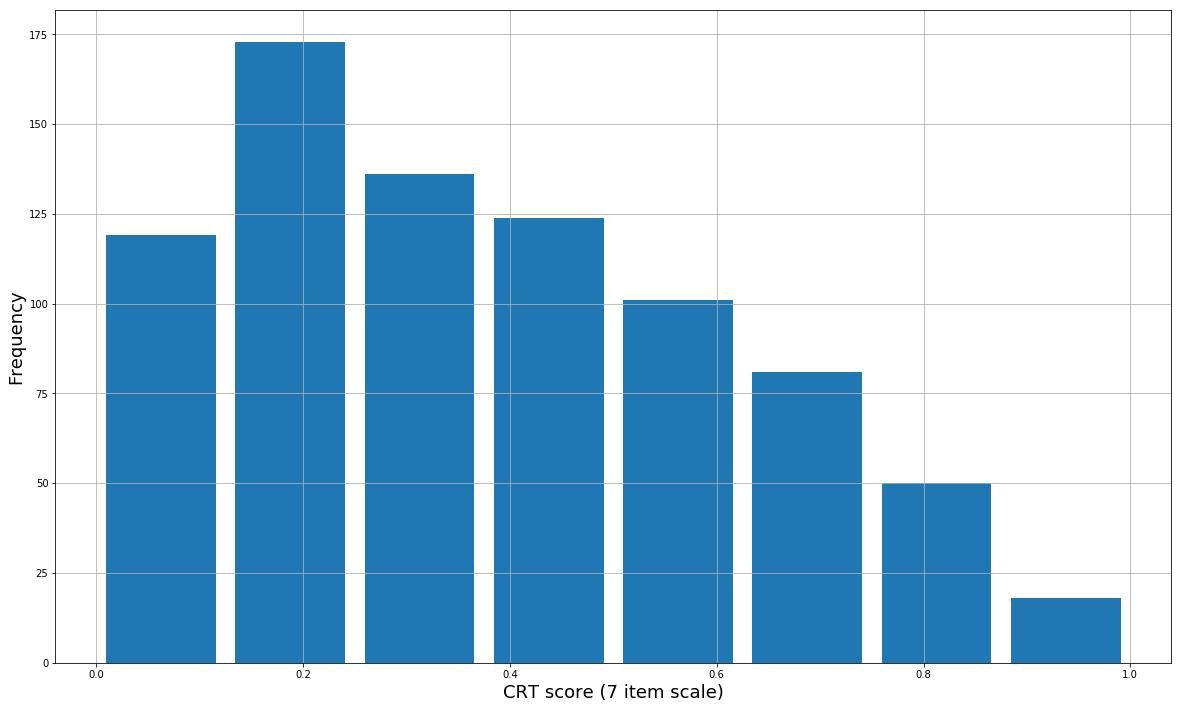

In [3]:
# CRT scores are well distributed

df1['CRT_Int'].hist(bins=8, rwidth=0.85)
plt.xlabel('CRT score (7 item scale)',fontsize=18)

plt.ylabel('Frequency',fontsize=18)

([<matplotlib.axis.XTick at 0x7fca91075390>,
 <a list of 11 Text xticklabel objects>)

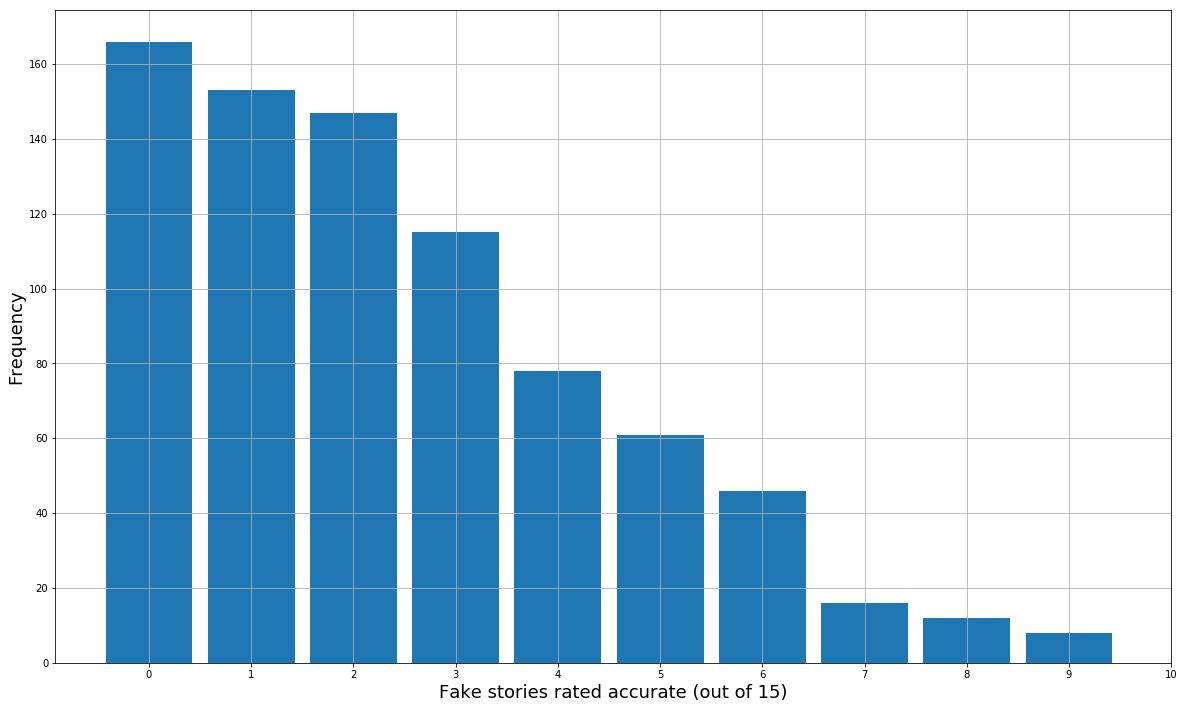

In [4]:
# Fake news stories are rated as accurate or inaccurate

# Let's make a histogram of the number of fake stories rated as accurate across all participants

#these are the variable names for 15 fake news stories

fakes=['Fake1_Accurate','Fake2_Accurate','Fake3_Accurate','Fake4_Accurate','Fake5_Accurate',
       'Fake6_Accurate','Fake7_Accurate','Fake8_Accurate','Fake9_Accurate','Fake10_Accurate',
       'Fake11_Accurate','Fake12_Accurate','Fake13_Accurate','Fake14_Accurate','Fake15_Accurate']

df1[fakes].sum(axis=1).hist(rwidth=0.85)
plt.xlabel('Fake stories rated accurate (out of 15)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xticks(np.arange(0.5,11,1),[str(a) for a in range(11)]) #make it clear which each column represents


# Lazy or biased?

Is this a fair (additional) tests of the relation between cognitive reflection and surceptibility to fake news?

Dan: "a logistic regression on "1 or more [=1] vs 0 [=0]" fake stories viewed as "accurate" w/ CRT score as predictor"
http://www.culturalcognition.net/blog/2018/10/25/who-falls-for-fake-news-apparently-no-one.html

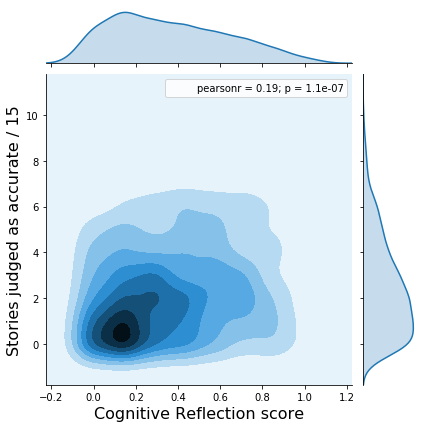

In [8]:
#Let's do a simple correlation first

#Because there is a large sample and a limited number of values on both the x and y axis,
#it is better to plot a heatmap rather than a scatterplot

ax = sns.jointplot(df1['CRT_Int'], df1[fakes].sum(axis=1), kind="kde")
ax.set_axis_labels('Cognitive Reflection score','Stories judged as accurate / 15', fontsize=16)



So there is a small but positive correlation between CRT and mumber of fakes rated as accurate

# BUT!

This analysis doesn't divide participants by partisan bias

Nor does it divide the fakes by political orientation

Nor am I sure which are the right variables to look at

# - - - Questions about the data coding - - - 

## 1 This variable codes forced choice between Clinton and Trump?

## Can we assume 1 = Clinton, 2 = Trump?

In [21]:
print(df1[df1['ClintonTrump']=='1']['Conserv'].mean())

print(df1[df1['ClintonTrump']=='2']['Conserv'].mean())

2.113871635610766
3.5630914826498423


# Acknowledgements

This analysis only possible because the study authors made their raw data available. Responsibility for errors of analysis and intepretation remains mine alone.